<a href="https://colab.research.google.com/github/Akashsky123/Deep-Learning-Lab/blob/main/Experiment-4/Experiment4_Cats_vs_Dogs_CNN%20(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EXPERIMENT 4: CNN IMPLEMENTATION - CATS VS DOGS

## Objective
Implement CNNs to classify images in the Cats vs. Dogs dataset with:
- 3 Activation Functions (ReLU, Tanh, Leaky ReLU)
- 3 Weight Initialization Techniques (Xavier, Kaiming, Random)
- 3 Optimizers (SGD, Adam, RMSprop)
- Compare with ResNet-18

Each experiment runs for **3 epochs**.

## CELL 1: Install Required Libraries

In [2]:
!pip install torch torchvision kaggle -q

## CELL 2: Import Libraries

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import zipfile
from sklearn.model_selection import train_test_split
import shutil
from tqdm import tqdm
import json

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## CELL 3: Setup Kaggle API and Download Dataset

In [4]:
# Upload your kaggle.json file first
from google.colab import files
uploaded = files.upload()

# Setup Kaggle credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download Cats vs Dogs dataset
!kaggle competitions download -c dogs-vs-cats
!unzip -q dogs-vs-cats.zip
!unzip -q train.zip

Saving kaggle.json to kaggle.json
 94% 761M/812M [00:03<00:00, 170MB/s]
100% 812M/812M [00:05<00:00, 167MB/s]


## CELL 4: Organize Dataset into Train/Val Splits

In [5]:
def organize_dataset(source_dir='train', base_dir='dataset', val_split=0.2):
    """
    Organize the dataset into train/val folders with cat/dog subfolders
    """
    # Create directory structure
    for split in ['train', 'val']:
        for category in ['cat', 'dog']:
            os.makedirs(os.path.join(base_dir, split, category), exist_ok=True)

    # Get all image files
    all_files = [f for f in os.listdir(source_dir) if f.endswith('.jpg')]

    # Separate cats and dogs
    cat_files = [f for f in all_files if f.startswith('cat')]
    dog_files = [f for f in all_files if f.startswith('dog')]

    # Split each category
    for category, files in [('cat', cat_files), ('dog', dog_files)]:
        train_files, val_files = train_test_split(files, test_size=val_split, random_state=42)

        # Copy files to appropriate directories
        for f in tqdm(train_files, desc=f'Processing {category} train'):
            src = os.path.join(source_dir, f)
            dst = os.path.join(base_dir, 'train', category, f)
            if os.path.exists(src):
                shutil.copy(src, dst)

        for f in tqdm(val_files, desc=f'Processing {category} val'):
            src = os.path.join(source_dir, f)
            dst = os.path.join(base_dir, 'val', category, f)
            if os.path.exists(src):
                shutil.copy(src, dst)

    print("Dataset organization complete!")
    print(f"Train - Cats: {len(os.listdir(os.path.join(base_dir, 'train', 'cat')))}")
    print(f"Train - Dogs: {len(os.listdir(os.path.join(base_dir, 'train', 'dog')))}")
    print(f"Val - Cats: {len(os.listdir(os.path.join(base_dir, 'val', 'cat')))}")
    print(f"Val - Dogs: {len(os.listdir(os.path.join(base_dir, 'val', 'dog')))}")

# Run organization
organize_dataset()

Processing dog val: 100%|██████████| 2500/2500 [00:00<00:00, 8679.10it/s]


Dataset organization complete!
Train - Cats: 10000
Train - Dogs: 10000
Val - Cats: 2500
Val - Dogs: 2500


## CELL 5: Data Transforms and Loaders

In [9]:
# Data augmentation and normalization
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets and loaders
batch_size = 64

train_dataset = ImageFolder('dataset/train', transform=train_transform)
val_dataset = ImageFolder('dataset/val', transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Classes: {train_dataset.classes}")

Training samples: 20000
Validation samples: 5000
Classes: ['cat', 'dog']


## CELL 6: Weight Initialization Functions

In [11]:
def xavier_init(m):
    """Xavier/Glorot initialization"""
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

def kaiming_init(m):
    """Kaiming/He initialization"""
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

def random_init(m):
    """Random initialization"""
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.uniform_(m.weight, -0.1, 0.1)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

## CELL 7: CNN Model Architecture

In [12]:
class CatDogCNN(nn.Module):
    def __init__(self, activation='relu', num_classes=2):
        super(CatDogCNN, self).__init__()

        # Choose activation function
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'leaky_relu':
            self.activation = nn.LeakyReLU(0.2)

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        # Block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.pool1(x)

        # Block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.activation(x)
        x = self.pool2(x)

        # Block 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.activation(x)
        x = self.pool3(x)

        # Block 4
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.activation(x)
        x = self.pool4(x)

        # Fully connected
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.dropout2(x)
        x = self.fc3(x)

        return x

## CELL 8: Training Function

In [13]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=3, device='cuda'):
    """
    Train the model and return training history
    """
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    model.to(device)

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for images, labels in train_bar:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Statistics
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            # Update progress bar
            train_bar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100 * train_correct / train_total:.2f}%'
            })

        # Calculate average training metrics
        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = 100 * train_correct / train_total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            val_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
            for images, labels in val_bar:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                val_bar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'acc': f'{100 * val_correct / val_total:.2f}%'
                })

        # Calculate average validation metrics
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total

        # Save history
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_accuracy)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_accuracy)

        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%')
        print(f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%\n')

    return history

## CELL 9: Experiment Configuration

In [14]:
# Define all combinations
activations = ['relu', 'tanh', 'leaky_relu']
initializations = {
    'xavier': xavier_init,
    'kaiming': kaiming_init,
    'random': random_init
}
optimizers_config = ['sgd', 'adam', 'rmsprop']

# Store results
results = []

## CELL 10: Run All Experiments (27 combinations × 3 epochs each)

In [15]:
num_epochs = 3
best_accuracy = 0
best_config = None
best_model_state = None

experiment_num = 0
total_experiments = len(activations) * len(initializations) * len(optimizers_config)

for activation in activations:
    for init_name, init_func in initializations.items():
        for opt_name in optimizers_config:
            experiment_num += 1
            print(f"\n{'='*80}")
            print(f"EXPERIMENT {experiment_num}/{total_experiments}")
            print(f"Activation: {activation} | Initialization: {init_name} | Optimizer: {opt_name}")
            print(f"{'='*80}\n")

            # Create model
            model = CatDogCNN(activation=activation)
            model.apply(init_func)
            model.to(device)

            # Setup optimizer
            if opt_name == 'sgd':
                optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
            elif opt_name == 'adam':
                optimizer = optim.Adam(model.parameters(), lr=0.001)
            elif opt_name == 'rmsprop':
                optimizer = optim.RMSprop(model.parameters(), lr=0.001)

            # Loss function
            criterion = nn.CrossEntropyLoss()

            # Train model
            history = train_model(
                model, train_loader, val_loader,
                criterion, optimizer,
                num_epochs=num_epochs,
                device=device
            )

            # Get final validation accuracy
            final_val_acc = history['val_acc'][-1]

            # Save results
            result = {
                'activation': activation,
                'initialization': init_name,
                'optimizer': opt_name,
                'final_train_acc': history['train_acc'][-1],
                'final_val_acc': final_val_acc,
                'final_train_loss': history['train_loss'][-1],
                'final_val_loss': history['val_loss'][-1],
                'history': history
            }
            results.append(result)

            # Check if this is the best model
            if final_val_acc > best_accuracy:
                best_accuracy = final_val_acc
                best_config = {
                    'activation': activation,
                    'initialization': init_name,
                    'optimizer': opt_name
                }
                best_model_state = model.state_dict().copy()
                print(f"\n NEW BEST MODEL! Validation Accuracy: {best_accuracy:.2f}%\n")

print(f"\n{'='*80}")
print("ALL EXPERIMENTS COMPLETED!")
print(f"{'='*80}")
print(f"\nBest Configuration:")
print(f"Activation: {best_config['activation']}")
print(f"Initialization: {best_config['initialization']}")
print(f"Optimizer: {best_config['optimizer']}")
print(f"Best Validation Accuracy: {best_accuracy:.2f}%")


EXPERIMENT 1/27
Activation: relu | Initialization: xavier | Optimizer: sgd



Epoch 1/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  7.15it/s, loss=0.5949, acc=63.16%]



Epoch 1/3:
Train Loss: 0.7421, Train Acc: 56.70%
Val Loss: 0.6403, Val Acc: 63.16%



Epoch 2/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.65it/s, loss=0.3334, acc=72.44%]



Epoch 2/3:
Train Loss: 0.6079, Train Acc: 66.39%
Val Loss: 0.5391, Val Acc: 72.44%



Epoch 3/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.71it/s, loss=0.6430, acc=71.80%]



Epoch 3/3:
Train Loss: 0.5712, Train Acc: 70.15%
Val Loss: 0.5484, Val Acc: 71.80%


 NEW BEST MODEL! Validation Accuracy: 71.80%


EXPERIMENT 2/27
Activation: relu | Initialization: xavier | Optimizer: adam



Epoch 1/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.62it/s, loss=0.6584, acc=53.26%]



Epoch 1/3:
Train Loss: 1.2196, Train Acc: 51.94%
Val Loss: 0.6882, Val Acc: 53.26%



Epoch 2/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.68it/s, loss=0.6754, acc=57.60%]



Epoch 2/3:
Train Loss: 0.6891, Train Acc: 53.56%
Val Loss: 0.6799, Val Acc: 57.60%



Epoch 3/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.68it/s, loss=0.6289, acc=54.54%]



Epoch 3/3:
Train Loss: 0.6853, Train Acc: 54.91%
Val Loss: 0.6862, Val Acc: 54.54%


EXPERIMENT 3/27
Activation: relu | Initialization: xavier | Optimizer: rmsprop



Epoch 1/3 [Val]: 100%|██████████| 79/79 [00:10<00:00,  7.25it/s, loss=0.6824, acc=50.04%]



Epoch 1/3:
Train Loss: 5.5795, Train Acc: 51.06%
Val Loss: 0.6925, Val Acc: 50.04%



Epoch 2/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.65it/s, loss=0.6877, acc=50.00%]



Epoch 2/3:
Train Loss: 0.6950, Train Acc: 49.99%
Val Loss: 0.6917, Val Acc: 50.00%



Epoch 3/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.66it/s, loss=0.6774, acc=50.00%]



Epoch 3/3:
Train Loss: 0.7031, Train Acc: 49.73%
Val Loss: 0.6932, Val Acc: 50.00%


EXPERIMENT 4/27
Activation: relu | Initialization: kaiming | Optimizer: sgd



Epoch 1/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.66it/s, loss=0.5386, acc=63.36%]



Epoch 1/3:
Train Loss: 0.7787, Train Acc: 57.38%
Val Loss: 0.6515, Val Acc: 63.36%



Epoch 2/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.59it/s, loss=0.6546, acc=67.64%]



Epoch 2/3:
Train Loss: 0.6400, Train Acc: 61.31%
Val Loss: 0.6017, Val Acc: 67.64%



Epoch 3/3 [Val]: 100%|██████████| 79/79 [00:10<00:00,  7.20it/s, loss=0.4439, acc=73.56%]



Epoch 3/3:
Train Loss: 0.6104, Train Acc: 65.51%
Val Loss: 0.5522, Val Acc: 73.56%


 NEW BEST MODEL! Validation Accuracy: 73.56%


EXPERIMENT 5/27
Activation: relu | Initialization: kaiming | Optimizer: adam



Epoch 1/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.59it/s, loss=0.5263, acc=60.86%]



Epoch 1/3:
Train Loss: 1.4808, Train Acc: 53.21%
Val Loss: 0.6536, Val Acc: 60.86%



Epoch 2/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.85it/s, loss=0.4790, acc=63.38%]



Epoch 2/3:
Train Loss: 0.6753, Train Acc: 56.51%
Val Loss: 0.6326, Val Acc: 63.38%



Epoch 3/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.67it/s, loss=0.4660, acc=65.30%]



Epoch 3/3:
Train Loss: 0.6616, Train Acc: 59.38%
Val Loss: 0.6248, Val Acc: 65.30%


EXPERIMENT 6/27
Activation: relu | Initialization: kaiming | Optimizer: rmsprop



Epoch 1/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.62it/s, loss=0.8089, acc=51.10%]



Epoch 1/3:
Train Loss: 5.4646, Train Acc: 53.80%
Val Loss: 0.7075, Val Acc: 51.10%



Epoch 2/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.72it/s, loss=0.7037, acc=50.68%]



Epoch 2/3:
Train Loss: 0.6982, Train Acc: 51.91%
Val Loss: 0.6925, Val Acc: 50.68%



Epoch 3/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.61it/s, loss=0.6909, acc=50.00%]



Epoch 3/3:
Train Loss: 0.6942, Train Acc: 49.89%
Val Loss: 0.6932, Val Acc: 50.00%


EXPERIMENT 7/27
Activation: relu | Initialization: random | Optimizer: sgd



Epoch 1/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  7.03it/s, loss=0.6507, acc=50.00%]



Epoch 1/3:
Train Loss: 0.8686, Train Acc: 52.41%
Val Loss: 0.6935, Val Acc: 50.00%



Epoch 2/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.74it/s, loss=0.6694, acc=56.12%]



Epoch 2/3:
Train Loss: 0.6924, Train Acc: 52.98%
Val Loss: 0.6841, Val Acc: 56.12%



Epoch 3/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  7.06it/s, loss=0.6439, acc=51.94%]



Epoch 3/3:
Train Loss: 0.6868, Train Acc: 54.38%
Val Loss: 0.6860, Val Acc: 51.94%


EXPERIMENT 8/27
Activation: relu | Initialization: random | Optimizer: adam



Epoch 1/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.72it/s, loss=0.5819, acc=60.38%]



Epoch 1/3:
Train Loss: 1.0910, Train Acc: 55.16%
Val Loss: 0.6409, Val Acc: 60.38%



Epoch 2/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.70it/s, loss=0.4749, acc=69.56%]



Epoch 2/3:
Train Loss: 0.6510, Train Acc: 60.05%
Val Loss: 0.6006, Val Acc: 69.56%



Epoch 3/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.77it/s, loss=0.3156, acc=63.18%]



Epoch 3/3:
Train Loss: 0.6371, Train Acc: 62.50%
Val Loss: 0.6948, Val Acc: 63.18%


EXPERIMENT 9/27
Activation: relu | Initialization: random | Optimizer: rmsprop



Epoch 1/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.72it/s, loss=0.7010, acc=55.72%]



Epoch 1/3:
Train Loss: 3.9193, Train Acc: 51.66%
Val Loss: 0.6867, Val Acc: 55.72%



Epoch 2/3 [Val]: 100%|██████████| 79/79 [00:10<00:00,  7.20it/s, loss=0.6939, acc=53.58%]



Epoch 2/3:
Train Loss: 0.7026, Train Acc: 51.58%
Val Loss: 0.6870, Val Acc: 53.58%



Epoch 3/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.74it/s, loss=0.6119, acc=57.32%]



Epoch 3/3:
Train Loss: 0.6964, Train Acc: 54.26%
Val Loss: 0.6626, Val Acc: 57.32%


EXPERIMENT 10/27
Activation: tanh | Initialization: xavier | Optimizer: sgd



Epoch 1/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  7.12it/s, loss=0.3861, acc=68.88%]



Epoch 1/3:
Train Loss: 0.6870, Train Acc: 60.62%
Val Loss: 0.5743, Val Acc: 68.88%



Epoch 2/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.72it/s, loss=0.2698, acc=64.12%]



Epoch 2/3:
Train Loss: 0.6223, Train Acc: 65.94%
Val Loss: 0.6595, Val Acc: 64.12%



Epoch 3/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.79it/s, loss=0.3449, acc=72.34%]



Epoch 3/3:
Train Loss: 0.5982, Train Acc: 67.95%
Val Loss: 0.5310, Val Acc: 72.34%


EXPERIMENT 11/27
Activation: tanh | Initialization: xavier | Optimizer: adam



Epoch 1/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.67it/s, loss=0.5341, acc=55.78%]



Epoch 1/3:
Train Loss: 0.8222, Train Acc: 54.84%
Val Loss: 0.7346, Val Acc: 55.78%



Epoch 2/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.71it/s, loss=0.5931, acc=62.04%]



Epoch 2/3:
Train Loss: 0.7057, Train Acc: 56.01%
Val Loss: 0.6449, Val Acc: 62.04%



Epoch 3/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.60it/s, loss=0.5400, acc=64.54%]



Epoch 3/3:
Train Loss: 0.6675, Train Acc: 59.68%
Val Loss: 0.6199, Val Acc: 64.54%


EXPERIMENT 12/27
Activation: tanh | Initialization: xavier | Optimizer: rmsprop



Epoch 1/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.70it/s, loss=0.5848, acc=57.58%]



Epoch 1/3:
Train Loss: 0.8025, Train Acc: 54.38%
Val Loss: 0.6839, Val Acc: 57.58%



Epoch 2/3 [Val]: 100%|██████████| 79/79 [00:10<00:00,  7.24it/s, loss=0.4745, acc=63.16%]



Epoch 2/3:
Train Loss: 0.6904, Train Acc: 56.70%
Val Loss: 0.6398, Val Acc: 63.16%



Epoch 3/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.74it/s, loss=0.5969, acc=65.46%]



Epoch 3/3:
Train Loss: 0.6526, Train Acc: 61.63%
Val Loss: 0.6232, Val Acc: 65.46%


EXPERIMENT 13/27
Activation: tanh | Initialization: kaiming | Optimizer: sgd



Epoch 1/3 [Val]: 100%|██████████| 79/79 [00:10<00:00,  7.34it/s, loss=0.6571, acc=67.70%]



Epoch 1/3:
Train Loss: 0.7166, Train Acc: 58.53%
Val Loss: 0.5834, Val Acc: 67.70%



Epoch 2/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.67it/s, loss=0.4388, acc=72.20%]



Epoch 2/3:
Train Loss: 0.6342, Train Acc: 64.66%
Val Loss: 0.5355, Val Acc: 72.20%



Epoch 3/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.88it/s, loss=0.2936, acc=71.82%]



Epoch 3/3:
Train Loss: 0.6086, Train Acc: 67.42%
Val Loss: 0.5550, Val Acc: 71.82%


EXPERIMENT 14/27
Activation: tanh | Initialization: kaiming | Optimizer: adam



Epoch 1/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.69it/s, loss=0.6951, acc=56.50%]



Epoch 1/3:
Train Loss: 0.8137, Train Acc: 53.81%
Val Loss: 0.6860, Val Acc: 56.50%



Epoch 2/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.73it/s, loss=0.7556, acc=63.34%]



Epoch 2/3:
Train Loss: 0.6979, Train Acc: 57.39%
Val Loss: 0.6353, Val Acc: 63.34%



Epoch 3/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.64it/s, loss=0.5726, acc=65.26%]



Epoch 3/3:
Train Loss: 0.6523, Train Acc: 60.74%
Val Loss: 0.6102, Val Acc: 65.26%


EXPERIMENT 15/27
Activation: tanh | Initialization: kaiming | Optimizer: rmsprop



Epoch 1/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.67it/s, loss=0.6279, acc=54.18%]



Epoch 1/3:
Train Loss: 0.7951, Train Acc: 53.69%
Val Loss: 0.6873, Val Acc: 54.18%



Epoch 2/3 [Val]: 100%|██████████| 79/79 [00:10<00:00,  7.21it/s, loss=0.8488, acc=64.40%]



Epoch 2/3:
Train Loss: 0.6739, Train Acc: 58.38%
Val Loss: 0.6242, Val Acc: 64.40%



Epoch 3/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.59it/s, loss=0.8251, acc=66.90%]



Epoch 3/3:
Train Loss: 0.6360, Train Acc: 63.34%
Val Loss: 0.5988, Val Acc: 66.90%


EXPERIMENT 16/27
Activation: tanh | Initialization: random | Optimizer: sgd



Epoch 1/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.65it/s, loss=0.3534, acc=61.30%]



Epoch 1/3:
Train Loss: 0.7145, Train Acc: 56.36%
Val Loss: 0.6586, Val Acc: 61.30%



Epoch 2/3 [Val]: 100%|██████████| 79/79 [00:12<00:00,  6.54it/s, loss=0.4660, acc=62.76%]



Epoch 2/3:
Train Loss: 0.6891, Train Acc: 58.80%
Val Loss: 0.6288, Val Acc: 62.76%



Epoch 3/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.74it/s, loss=0.3497, acc=68.36%]



Epoch 3/3:
Train Loss: 0.6593, Train Acc: 62.49%
Val Loss: 0.5839, Val Acc: 68.36%


EXPERIMENT 17/27
Activation: tanh | Initialization: random | Optimizer: adam



Epoch 1/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  7.08it/s, loss=0.5480, acc=56.64%]



Epoch 1/3:
Train Loss: 0.7105, Train Acc: 57.28%
Val Loss: 0.6678, Val Acc: 56.64%



Epoch 2/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.73it/s, loss=0.6721, acc=59.58%]



Epoch 2/3:
Train Loss: 0.6490, Train Acc: 61.19%
Val Loss: 0.6916, Val Acc: 59.58%



Epoch 3/3 [Val]: 100%|██████████| 79/79 [00:10<00:00,  7.32it/s, loss=0.6596, acc=69.96%]



Epoch 3/3:
Train Loss: 0.6224, Train Acc: 64.95%
Val Loss: 0.5750, Val Acc: 69.96%


EXPERIMENT 18/27
Activation: tanh | Initialization: random | Optimizer: rmsprop



Epoch 1/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.76it/s, loss=0.7712, acc=57.46%]



Epoch 1/3:
Train Loss: 0.7426, Train Acc: 53.94%
Val Loss: 0.6804, Val Acc: 57.46%



Epoch 2/3 [Val]: 100%|██████████| 79/79 [00:10<00:00,  7.34it/s, loss=0.8495, acc=59.48%]



Epoch 2/3:
Train Loss: 0.6801, Train Acc: 57.06%
Val Loss: 0.6761, Val Acc: 59.48%



Epoch 3/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.77it/s, loss=0.6754, acc=65.48%]



Epoch 3/3:
Train Loss: 0.6577, Train Acc: 60.35%
Val Loss: 0.6203, Val Acc: 65.48%


EXPERIMENT 19/27
Activation: leaky_relu | Initialization: xavier | Optimizer: sgd



Epoch 1/3 [Val]: 100%|██████████| 79/79 [00:10<00:00,  7.21it/s, loss=0.5548, acc=64.98%]



Epoch 1/3:
Train Loss: 0.8970, Train Acc: 54.44%
Val Loss: 0.6367, Val Acc: 64.98%



Epoch 2/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.74it/s, loss=0.6665, acc=68.56%]



Epoch 2/3:
Train Loss: 0.6684, Train Acc: 62.03%
Val Loss: 0.5902, Val Acc: 68.56%



Epoch 3/3 [Val]: 100%|██████████| 79/79 [00:10<00:00,  7.29it/s, loss=0.3565, acc=67.04%]



Epoch 3/3:
Train Loss: 0.6138, Train Acc: 66.91%
Val Loss: 0.5839, Val Acc: 67.04%


EXPERIMENT 20/27
Activation: leaky_relu | Initialization: xavier | Optimizer: adam



Epoch 1/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.70it/s, loss=0.3339, acc=62.12%]



Epoch 1/3:
Train Loss: 1.6642, Train Acc: 56.92%
Val Loss: 0.6502, Val Acc: 62.12%



Epoch 2/3 [Val]: 100%|██████████| 79/79 [00:10<00:00,  7.18it/s, loss=0.6601, acc=70.40%]



Epoch 2/3:
Train Loss: 0.6934, Train Acc: 65.21%
Val Loss: 0.5953, Val Acc: 70.40%



Epoch 3/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.68it/s, loss=0.6011, acc=73.22%]



Epoch 3/3:
Train Loss: 0.6057, Train Acc: 69.46%
Val Loss: 0.5288, Val Acc: 73.22%


EXPERIMENT 21/27
Activation: leaky_relu | Initialization: xavier | Optimizer: rmsprop



Epoch 1/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  7.00it/s, loss=1.1315, acc=55.44%]



Epoch 1/3:
Train Loss: 8.2549, Train Acc: 53.46%
Val Loss: 0.8751, Val Acc: 55.44%



Epoch 2/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.74it/s, loss=0.0758, acc=50.48%]



Epoch 2/3:
Train Loss: 1.0058, Train Acc: 54.99%
Val Loss: 6.1614, Val Acc: 50.48%



Epoch 3/3 [Val]: 100%|██████████| 79/79 [00:10<00:00,  7.24it/s, loss=0.6757, acc=58.74%]



Epoch 3/3:
Train Loss: 0.8601, Train Acc: 58.41%
Val Loss: 0.7400, Val Acc: 58.74%


EXPERIMENT 22/27
Activation: leaky_relu | Initialization: kaiming | Optimizer: sgd



Epoch 1/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.77it/s, loss=0.5542, acc=69.04%]



Epoch 1/3:
Train Loss: 1.0128, Train Acc: 56.87%
Val Loss: 0.5959, Val Acc: 69.04%



Epoch 2/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.79it/s, loss=0.8730, acc=65.18%]



Epoch 2/3:
Train Loss: 0.6709, Train Acc: 64.04%
Val Loss: 0.6342, Val Acc: 65.18%



Epoch 3/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.76it/s, loss=0.4287, acc=70.90%]



Epoch 3/3:
Train Loss: 0.6068, Train Acc: 68.05%
Val Loss: 0.5471, Val Acc: 70.90%


EXPERIMENT 23/27
Activation: leaky_relu | Initialization: kaiming | Optimizer: adam



Epoch 1/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.64it/s, loss=0.3983, acc=59.72%]



Epoch 1/3:
Train Loss: 2.2537, Train Acc: 52.81%
Val Loss: 0.6809, Val Acc: 59.72%



Epoch 2/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.78it/s, loss=0.4109, acc=65.74%]



Epoch 2/3:
Train Loss: 0.8244, Train Acc: 59.86%
Val Loss: 0.5991, Val Acc: 65.74%



Epoch 3/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.74it/s, loss=0.7093, acc=68.46%]



Epoch 3/3:
Train Loss: 0.6786, Train Acc: 64.16%
Val Loss: 0.5895, Val Acc: 68.46%


EXPERIMENT 24/27
Activation: leaky_relu | Initialization: kaiming | Optimizer: rmsprop



Epoch 1/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.66it/s, loss=2.0170, acc=52.08%]



Epoch 1/3:
Train Loss: 10.1212, Train Acc: 54.28%
Val Loss: 1.1194, Val Acc: 52.08%



Epoch 2/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.73it/s, loss=1.1325, acc=62.60%]



Epoch 2/3:
Train Loss: 1.0731, Train Acc: 58.10%
Val Loss: 0.6851, Val Acc: 62.60%



Epoch 3/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.77it/s, loss=0.4078, acc=69.76%]



Epoch 3/3:
Train Loss: 0.7689, Train Acc: 61.81%
Val Loss: 0.5919, Val Acc: 69.76%


EXPERIMENT 25/27
Activation: leaky_relu | Initialization: random | Optimizer: sgd



Epoch 1/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.80it/s, loss=0.2690, acc=50.54%]



Epoch 1/3:
Train Loss: 1.6265, Train Acc: 53.84%
Val Loss: 0.8758, Val Acc: 50.54%



Epoch 2/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.75it/s, loss=0.8147, acc=59.18%]



Epoch 2/3:
Train Loss: 0.7605, Train Acc: 58.31%
Val Loss: 0.7012, Val Acc: 59.18%



Epoch 3/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.70it/s, loss=0.5620, acc=69.06%]



Epoch 3/3:
Train Loss: 0.7026, Train Acc: 62.27%
Val Loss: 0.5941, Val Acc: 69.06%


EXPERIMENT 26/27
Activation: leaky_relu | Initialization: random | Optimizer: adam



Epoch 1/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.75it/s, loss=0.6866, acc=69.84%]



Epoch 1/3:
Train Loss: 1.5237, Train Acc: 58.65%
Val Loss: 0.5864, Val Acc: 69.84%



Epoch 2/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.70it/s, loss=0.5115, acc=73.88%]



Epoch 2/3:
Train Loss: 0.6624, Train Acc: 65.77%
Val Loss: 0.5328, Val Acc: 73.88%



Epoch 3/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.68it/s, loss=0.4412, acc=74.86%]



Epoch 3/3:
Train Loss: 0.5820, Train Acc: 69.31%
Val Loss: 0.5040, Val Acc: 74.86%


 NEW BEST MODEL! Validation Accuracy: 74.86%


EXPERIMENT 27/27
Activation: leaky_relu | Initialization: random | Optimizer: rmsprop



Epoch 1/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.74it/s, loss=0.1601, acc=51.40%]



Epoch 1/3:
Train Loss: 5.6448, Train Acc: 54.88%
Val Loss: 1.2491, Val Acc: 51.40%



Epoch 2/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.86it/s, loss=0.7248, acc=65.28%]



Epoch 2/3:
Train Loss: 0.7977, Train Acc: 60.02%
Val Loss: 0.6386, Val Acc: 65.28%



Epoch 3/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.76it/s, loss=1.1789, acc=54.44%]


Epoch 3/3:
Train Loss: 0.6716, Train Acc: 63.65%
Val Loss: 0.8327, Val Acc: 54.44%


ALL EXPERIMENTS COMPLETED!

Best Configuration:
Activation: leaky_relu
Initialization: random
Optimizer: adam
Best Validation Accuracy: 74.86%


## CELL 11: Save Best Model

In [16]:
# Save best model weights
os.makedirs('saved_models', exist_ok=True)
torch.save(best_model_state, 'saved_models/best_cnn_cats_vs_dogs.pth')

# Save configuration
with open('saved_models/best_config.json', 'w') as f:
    json.dump(best_config, f, indent=4)

print("Best model saved to 'saved_models/best_cnn_cats_vs_dogs.pth'")
print("Configuration saved to 'saved_models/best_config.json'")

Best model saved to 'saved_models/best_cnn_cats_vs_dogs.pth'
Configuration saved to 'saved_models/best_config.json'


## CELL 12: Results Summary Table

In [17]:
import pandas as pd

# Create results dataframe
results_df = pd.DataFrame([
    {
        'Activation': r['activation'],
        'Initialization': r['initialization'],
        'Optimizer': r['optimizer'],
        'Train Acc (%)': f"{r['final_train_acc']:.2f}",
        'Val Acc (%)': f"{r['final_val_acc']:.2f}",
        'Train Loss': f"{r['final_train_loss']:.4f}",
        'Val Loss': f"{r['final_val_loss']:.4f}"
    }
    for r in results
])

# Sort by validation accuracy
results_df = results_df.sort_values('Val Acc (%)', ascending=False)
results_df.reset_index(drop=True, inplace=True)

print("\nEXPERIMENT RESULTS SUMMARY:")
print(results_df.to_string(index=False))

# Save to CSV
results_df.to_csv('experiment_results.csv', index=False)
print("\nResults saved to 'experiment_results.csv'")


EXPERIMENT RESULTS SUMMARY:
Activation Initialization Optimizer Train Acc (%) Val Acc (%) Train Loss Val Loss
leaky_relu         random      adam         69.31       74.86     0.5820   0.5040
      relu        kaiming       sgd         65.51       73.56     0.6104   0.5522
leaky_relu         xavier      adam         69.46       73.22     0.6057   0.5288
      tanh         xavier       sgd         67.95       72.34     0.5982   0.5310
      tanh        kaiming       sgd         67.42       71.82     0.6086   0.5550
      relu         xavier       sgd         70.15       71.80     0.5712   0.5484
leaky_relu        kaiming       sgd         68.05       70.90     0.6068   0.5471
      tanh         random      adam         64.95       69.96     0.6224   0.5750
leaky_relu        kaiming   rmsprop         61.81       69.76     0.7689   0.5919
leaky_relu         random       sgd         62.27       69.06     0.7026   0.5941
leaky_relu        kaiming      adam         64.16       68.46     0.6

## CELL 13: Visualize Results

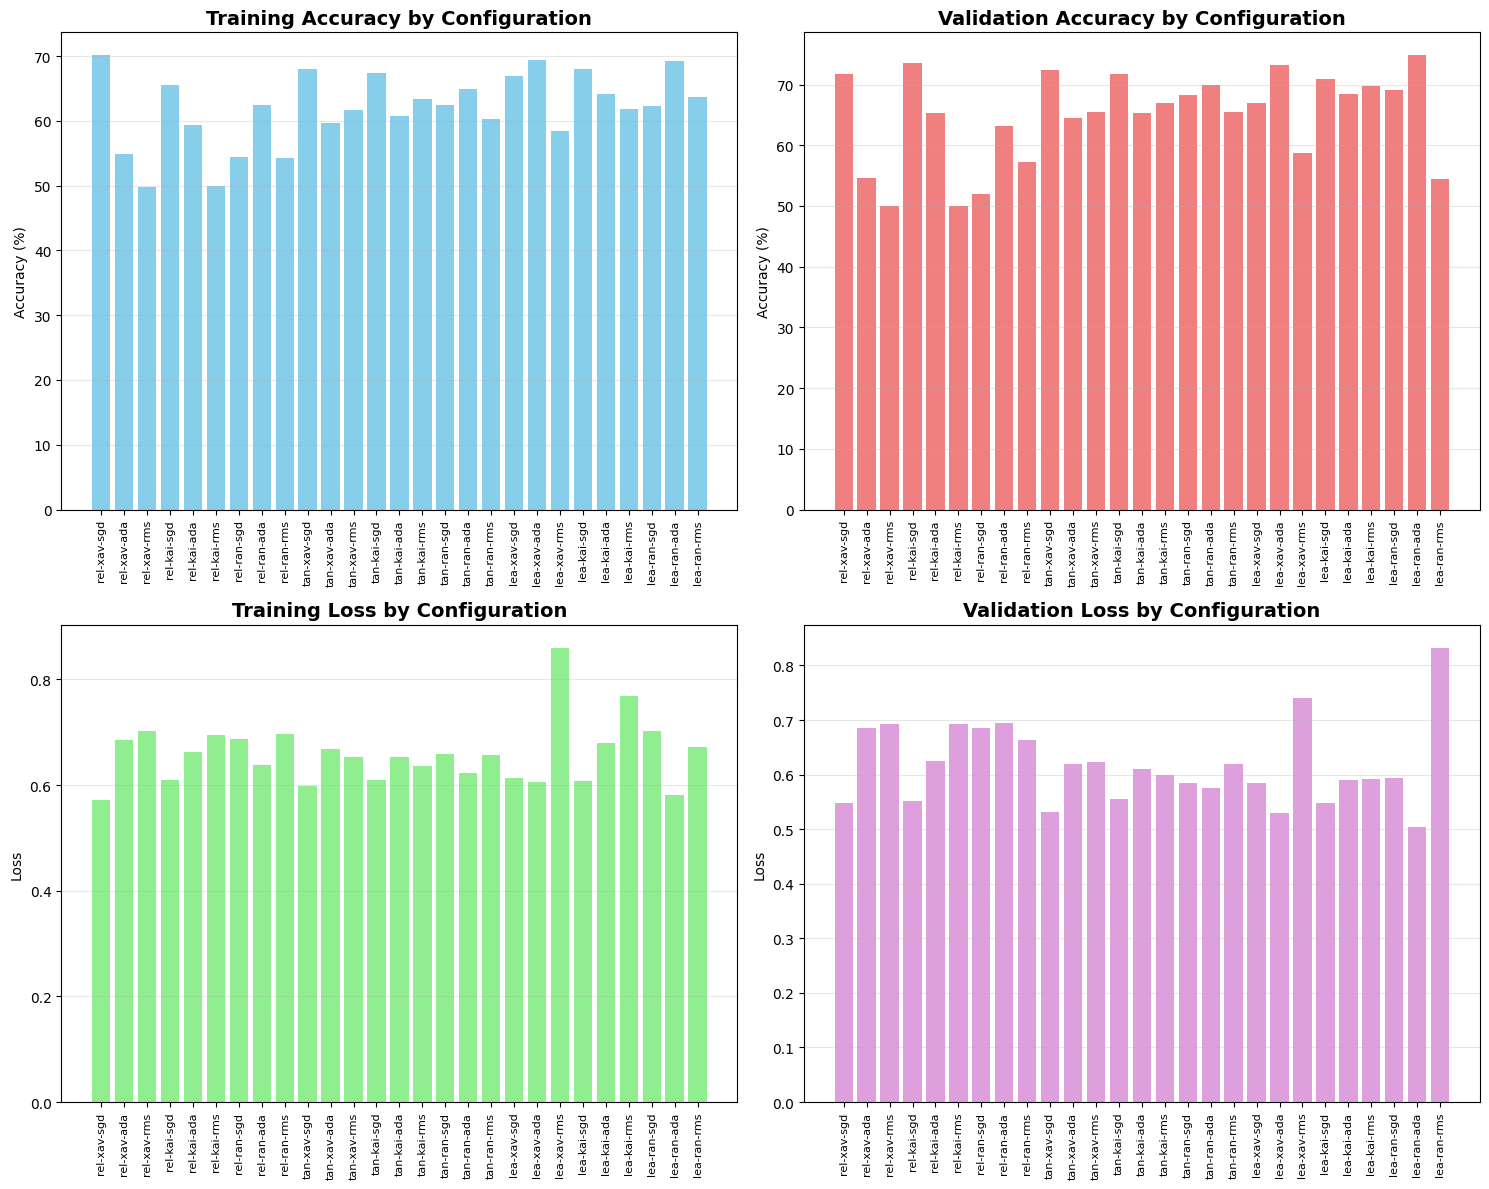

Comparison plot saved to 'experiment_comparison.png'


In [18]:
# Plot comparison of all experiments
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Extract data for plotting
configs = [f"{r['activation'][:3]}-{r['initialization'][:3]}-{r['optimizer'][:3]}"
           for r in results]
train_accs = [r['final_train_acc'] for r in results]
val_accs = [r['final_val_acc'] for r in results]
train_losses = [r['final_train_loss'] for r in results]
val_losses = [r['final_val_loss'] for r in results]

# Training Accuracy
axes[0, 0].bar(range(len(configs)), train_accs, color='skyblue')
axes[0, 0].set_title('Training Accuracy by Configuration', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Accuracy (%)')
axes[0, 0].set_xticks(range(len(configs)))
axes[0, 0].set_xticklabels(configs, rotation=90, fontsize=8)
axes[0, 0].grid(axis='y', alpha=0.3)

# Validation Accuracy
axes[0, 1].bar(range(len(configs)), val_accs, color='lightcoral')
axes[0, 1].set_title('Validation Accuracy by Configuration', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_xticks(range(len(configs)))
axes[0, 1].set_xticklabels(configs, rotation=90, fontsize=8)
axes[0, 1].grid(axis='y', alpha=0.3)

# Training Loss
axes[1, 0].bar(range(len(configs)), train_losses, color='lightgreen')
axes[1, 0].set_title('Training Loss by Configuration', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_xticks(range(len(configs)))
axes[1, 0].set_xticklabels(configs, rotation=90, fontsize=8)
axes[1, 0].grid(axis='y', alpha=0.3)

# Validation Loss
axes[1, 1].bar(range(len(configs)), val_losses, color='plum')
axes[1, 1].set_title('Validation Loss by Configuration', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].set_xticks(range(len(configs)))
axes[1, 1].set_xticklabels(configs, rotation=90, fontsize=8)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('experiment_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Comparison plot saved to 'experiment_comparison.png'")

## CELL 14: Plot Best Model Training History

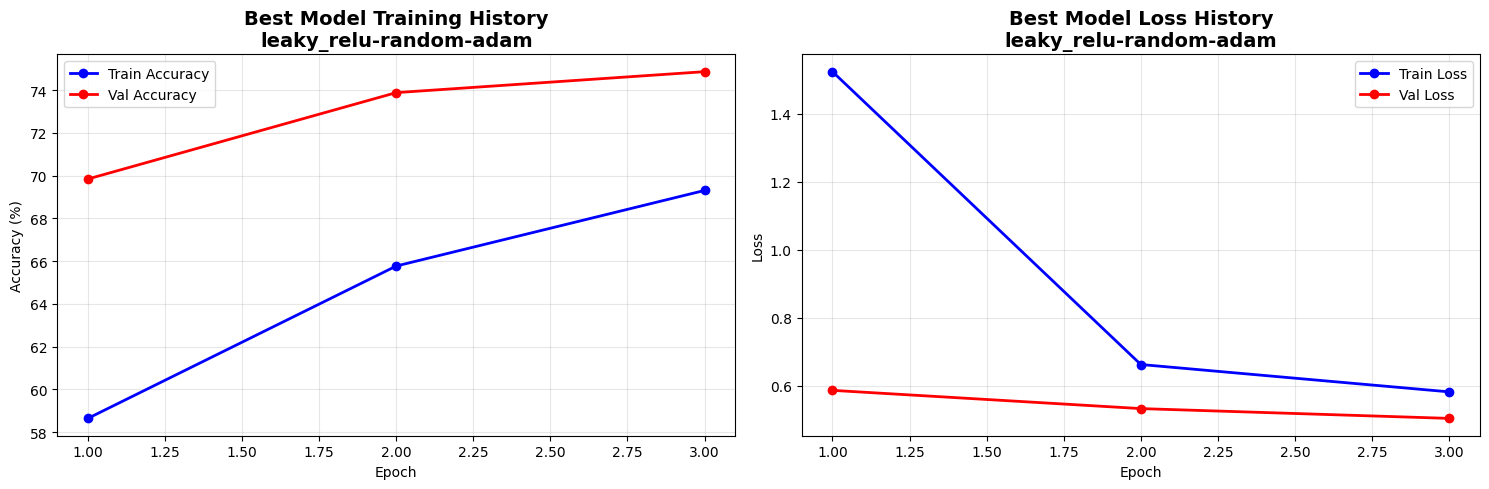

Best model history plot saved to 'best_model_history.png'


In [19]:
# Find best model's history
best_result = max(results, key=lambda x: x['final_val_acc'])
best_history = best_result['history']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
epochs_range = range(1, num_epochs + 1)
ax1.plot(epochs_range, best_history['train_acc'], 'b-o', label='Train Accuracy', linewidth=2)
ax1.plot(epochs_range, best_history['val_acc'], 'r-o', label='Val Accuracy', linewidth=2)
ax1.set_title(f'Best Model Training History\n{best_config["activation"]}-{best_config["initialization"]}-{best_config["optimizer"]}',
              fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy (%)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Loss plot
ax2.plot(epochs_range, best_history['train_loss'], 'b-o', label='Train Loss', linewidth=2)
ax2.plot(epochs_range, best_history['val_loss'], 'r-o', label='Val Loss', linewidth=2)
ax2.set_title(f'Best Model Loss History\n{best_config["activation"]}-{best_config["initialization"]}-{best_config["optimizer"]}',
              fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('best_model_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("Best model history plot saved to 'best_model_history.png'")

## CELL 15: Transfer Learning - ResNet18

In [20]:
print("\n" + "="*80)
print("TRANSFER LEARNING: ResNet-18")
print("="*80 + "\n")

# Load pretrained ResNet-18
resnet18 = models.resnet18(pretrained=True)

# Freeze all layers except the final layer
for param in resnet18.parameters():
    param.requires_grad = False

# Replace final layer for binary classification
num_features = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_features, 2)

resnet18.to(device)

# Setup optimizer and loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.fc.parameters(), lr=0.001)

# Train ResNet-18
print("Training ResNet-18 (fine-tuning last layer only)...\n")
resnet_history = train_model(
    resnet18, train_loader, val_loader,
    criterion, optimizer,
    num_epochs=num_epochs,
    device=device
)

# Save ResNet-18 model
torch.save(resnet18.state_dict(), 'saved_models/resnet18_cats_vs_dogs.pth')
print("ResNet-18 model saved to 'saved_models/resnet18_cats_vs_dogs.pth'")


TRANSFER LEARNING: ResNet-18

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 44.7M/44.7M [00:00<00:00, 47.1MB/s]


Training ResNet-18 (fine-tuning last layer only)...



Epoch 1/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.69it/s, loss=0.0804, acc=91.08%]



Epoch 1/3:
Train Loss: 0.2983, Train Acc: 85.95%
Val Loss: 0.2069, Val Acc: 91.08%



Epoch 2/3 [Val]: 100%|██████████| 79/79 [00:12<00:00,  6.41it/s, loss=0.0906, acc=92.86%]



Epoch 2/3:
Train Loss: 0.2301, Train Acc: 89.84%
Val Loss: 0.1702, Val Acc: 92.86%



Epoch 3/3 [Val]: 100%|██████████| 79/79 [00:11<00:00,  6.72it/s, loss=0.0948, acc=92.82%]



Epoch 3/3:
Train Loss: 0.2205, Train Acc: 90.38%
Val Loss: 0.1715, Val Acc: 92.82%

ResNet-18 model saved to 'saved_models/resnet18_cats_vs_dogs.pth'


## CELL 16: Compare Best CNN with ResNet-18

In [21]:
print("\n" + "="*80)
print("MODEL COMPARISON: Best CNN vs ResNet-18")
print("="*80 + "\n")

comparison_data = {
    'Model': ['Best CNN', 'ResNet-18'],
    'Configuration': [
        f"{best_config['activation']}-{best_config['initialization']}-{best_config['optimizer']}",
        'Pretrained + Fine-tuned'
    ],
    'Train Acc (%)': [
        f"{best_history['train_acc'][-1]:.2f}",
        f"{resnet_history['train_acc'][-1]:.2f}"
    ],
    'Val Acc (%)': [
        f"{best_history['val_acc'][-1]:.2f}",
        f"{resnet_history['val_acc'][-1]:.2f}"
    ],
    'Train Loss': [
        f"{best_history['train_loss'][-1]:.4f}",
        f"{resnet_history['train_loss'][-1]:.4f}"
    ],
    'Val Loss': [
        f"{best_history['val_loss'][-1]:.4f}",
        f"{resnet_history['val_loss'][-1]:.4f}"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# Save comparison
comparison_df.to_csv('model_comparison.csv', index=False)
print("\nComparison saved to 'model_comparison.csv'")


MODEL COMPARISON: Best CNN vs ResNet-18

    Model           Configuration Train Acc (%) Val Acc (%) Train Loss Val Loss
 Best CNN  leaky_relu-random-adam         69.31       74.86     0.5820   0.5040
ResNet-18 Pretrained + Fine-tuned         90.38       92.82     0.2205   0.1715

Comparison saved to 'model_comparison.csv'


## CELL 17: Final Comparison Visualization

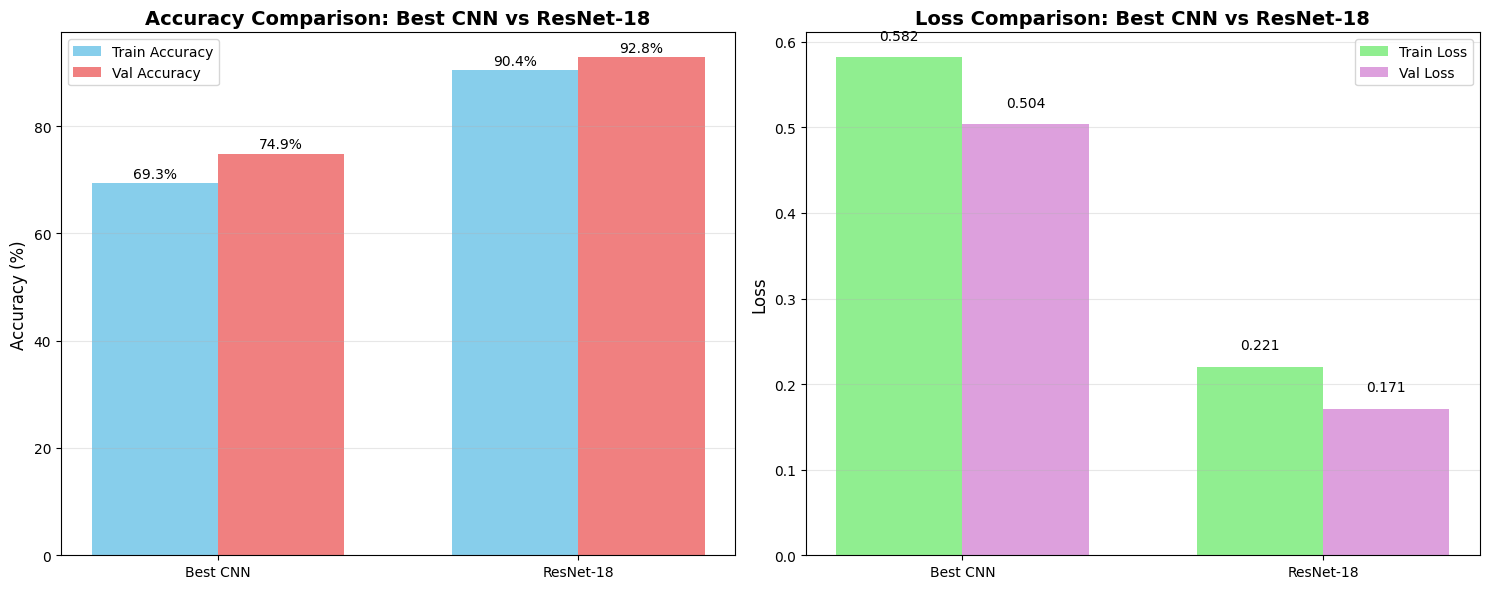

Final comparison plot saved to 'final_comparison.png'


In [22]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

models_names = ['Best CNN', 'ResNet-18']
train_accs = [best_history['train_acc'][-1], resnet_history['train_acc'][-1]]
val_accs = [best_history['val_acc'][-1], resnet_history['val_acc'][-1]]

x = np.arange(len(models_names))
width = 0.35

# Accuracy comparison
axes[0].bar(x - width/2, train_accs, width, label='Train Accuracy', color='skyblue')
axes[0].bar(x + width/2, val_accs, width, label='Val Accuracy', color='lightcoral')
axes[0].set_ylabel('Accuracy (%)', fontsize=12)
axes[0].set_title('Accuracy Comparison: Best CNN vs ResNet-18', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models_names)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (train, val) in enumerate(zip(train_accs, val_accs)):
    axes[0].text(i - width/2, train + 1, f'{train:.1f}%', ha='center', fontsize=10)
    axes[0].text(i + width/2, val + 1, f'{val:.1f}%', ha='center', fontsize=10)

# Loss comparison
train_losses = [best_history['train_loss'][-1], resnet_history['train_loss'][-1]]
val_losses = [best_history['val_loss'][-1], resnet_history['val_loss'][-1]]

axes[1].bar(x - width/2, train_losses, width, label='Train Loss', color='lightgreen')
axes[1].bar(x + width/2, val_losses, width, label='Val Loss', color='plum')
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Loss Comparison: Best CNN vs ResNet-18', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(models_names)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (train, val) in enumerate(zip(train_losses, val_losses)):
    axes[1].text(i - width/2, train + 0.02, f'{train:.3f}', ha='center', fontsize=10)
    axes[1].text(i + width/2, val + 0.02, f'{val:.3f}', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('final_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Final comparison plot saved to 'final_comparison.png'")

## CELL 18: Download All Results

In [23]:
# Zip all results for download
!zip -r experiment4_results.zip saved_models/ *.csv *.png *.json

# Download the zip file
from google.colab import files
files.download('experiment4_results.zip')

print("\n" + "="*80)
print("EXPERIMENT COMPLETED SUCCESSFULLY!")
print("="*80)
print("\nFiles generated:")
print("1. saved_models/best_cnn_cats_vs_dogs.pth")
print("2. saved_models/resnet18_cats_vs_dogs.pth")
print("3. saved_models/best_config.json")
print("4. experiment_results.csv")
print("5. model_comparison.csv")
print("6. experiment_comparison.png")
print("7. best_model_history.png")
print("8. final_comparison.png")

  adding: saved_models/ (stored 0%)
  adding: saved_models/best_cnn_cats_vs_dogs.pth (deflated 9%)
  adding: saved_models/best_config.json (deflated 21%)
  adding: saved_models/resnet18_cats_vs_dogs.pth (deflated 7%)
  adding: experiment_results.csv (deflated 60%)
  adding: model_comparison.csv (deflated 17%)
  adding: sampleSubmission.csv (deflated 68%)
  adding: best_model_history.png (deflated 17%)
  adding: experiment_comparison.png (deflated 28%)
  adding: final_comparison.png (deflated 27%)
  adding: kaggle.json (deflated 1%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


EXPERIMENT COMPLETED SUCCESSFULLY!

Files generated:
1. saved_models/best_cnn_cats_vs_dogs.pth
2. saved_models/resnet18_cats_vs_dogs.pth
3. saved_models/best_config.json
4. experiment_results.csv
5. model_comparison.csv
6. experiment_comparison.png
7. best_model_history.png
8. final_comparison.png
